#### Rasterdatenanalyse

<b>Rasterdaten analysieren</b>

Projection:  
Columns: 1198
Rows: 1177
Band count: 3
(1177, 1198)
<class 'numpy.ndarray'>
(1177, 1198)


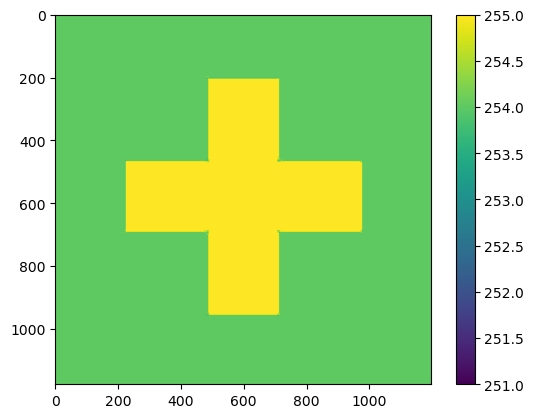

In [77]:
from osgeo import gdal
from osgeo import osr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


fn = "../Data/schweizerkreuz.png"
ds = gdal.Open(fn)

print("Projection: ", ds.GetProjection())  # get projection
print("Columns:", ds.RasterXSize)  # number of columns
print("Rows:", ds.RasterYSize)  # number of rows
print("Band count:", ds.RasterCount)  # number of bands

# Daten lesen
data_array_red = ds.GetRasterBand(1).ReadAsArray()
data_array_green = ds.GetRasterBand(2).ReadAsArray()
data_array_blue = ds.GetRasterBand(3).ReadAsArray()
print(data_array_red.shape)
print(type(data_array_blue))

data_array_red1200 = np.zeros(shape=(1200, 1200))
data_array_gren1200 = np.zeros(shape=(1200, 1200))
data_array_blue1200 = np.zeros(shape=(1200, 1200))
data_array_red1200 = data_array_red
print(data_array_red1200.shape)


plt.figure()
plt.imshow(data_array_red1200)
plt.colorbar()
ds = None

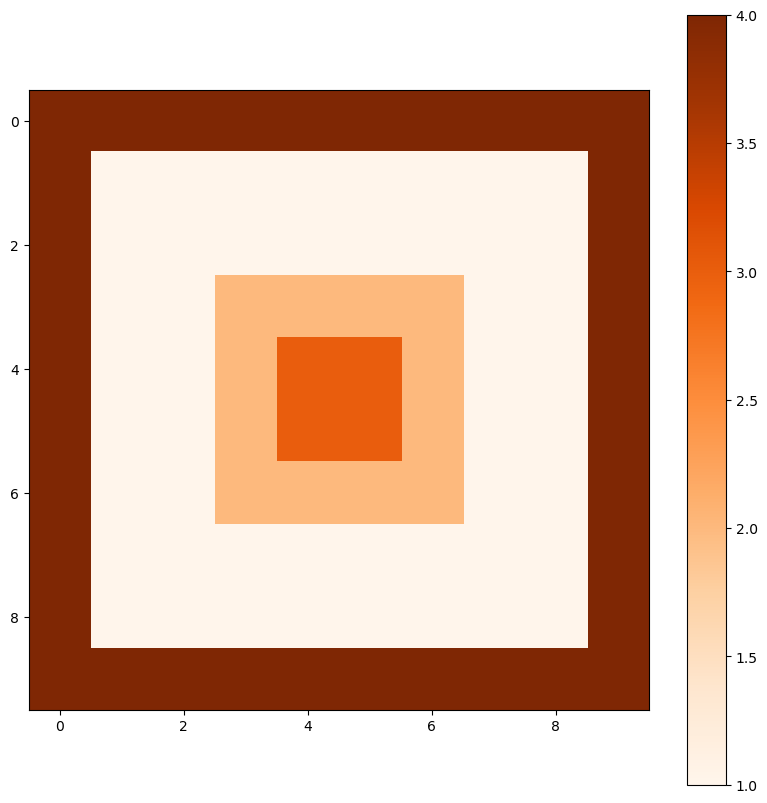

In [55]:
from osgeo import gdal
from osgeo import osr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['viridis']

fn_create = "../Data/gdalCreateRaster.tif"  # filename for new raster
driver_gtiff = gdal.GetDriverByName('GTiff')
ds_create = driver_gtiff.Create(fn_create, xsize=10, ysize=10, bands=1, eType=gdal.GDT_Byte)

srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds_create.SetProjection(srs.ExportToWkt())

geot_create = [7.6, 1.0, 0.0, 47.5, 0.0, -1.0]
ds_create.SetGeoTransform(geot_create)
#print(ds_create.GetGeoTransform())

data_create = np.zeros((10, 10))
data_create[1:-1, 1:-1] = 1  # values to 1, leave outer as 0 (no data)
data_create[3:-3, 3:-3] = 2  # set center group as 2
data_create[4:-4, 4:-4] = 3  # set center pixels to 3

i = 4
data_create[:1, :10] = i  # outest ring
data_create[9:10, :10] = i  # outest ring
data_create[:10, :1] = i  # outest ring
data_create[:10, 9:10] = i  # outest ring


ds_create.GetRasterBand(1).WriteArray(data_create)  # write the array to the raster
ds_create.GetRasterBand(1).SetNoDataValue(0)  # set the no data value
ds_create = None  # properly close the raster
# plot the data values we created
plt.figure(figsize=(10, 10))
plt.imshow(data_create, cmap='Oranges')
plt.colorbar()

##### Create MBRs from Gemeinden

In [ ]:
import osgeo.ogr
import osgeo.osr
import osgeo.gdal
import osgeo.gdalconst
import sys

sourcelayer = "../Data/Gemeinden_Solothurn.shp"
destinationlayername = "../Data/gemSoMBR.shp"
destinationformat = "ESRI Shapefile"
sourcefieldname = "name"

shapefile = osgeo.ogr.Open(sourcelayer)
sourcelayer = shapefile.GetLayer(0)
srs = osr.SpatialReference()
srs.ImportFromProj4(sourcelayer.GetSpatialRef().ExportToProj4())

driver = osgeo.ogr.GetDriverByName(destinationformat)
destinationFile = driver.CreateDataSource(destinationlayername)
destinationLayer = destinationFile.CreateLayer(destinationlayername[0:len(destinationlayername)-4], srs)

#Create Field to store the name
fieldDef = osgeo.ogr.FieldDefn(sourcefieldname, osgeo.ogr.OFTString)
fieldDef.SetWidth(100)
destinationLayer.CreateField(fieldDef)

feature = sourcelayer.GetNextFeature()
while feature:
    #Get value of Feature-Name
    ftrName = feature.GetField(sourcefieldname)
    #Get MBR
    geometry = feature.GetGeometryRef()
    minEasting,maxEasting,minNorthing,maxNorthing = geometry.GetEnvelope()
    #print("*"*20)
    #print(geometry.GetEnvelope())

    linearRing = osgeo.ogr.Geometry(osgeo.ogr.wkbLinearRing)
    linearRing.AddPoint(minEasting, minNorthing)
    linearRing.AddPoint(maxEasting, minNorthing)
    linearRing.AddPoint(maxEasting, maxNorthing)
    linearRing.AddPoint(minEasting, maxNorthing)
    linearRing.AddPoint(minEasting, minNorthing)
    mbr = osgeo.ogr.Geometry(osgeo.ogr.wkbPolygon)
    mbr.AddGeometry(linearRing)
    mbrfeature = osgeo.ogr.Feature(destinationLayer.GetLayerDefn())
    mbrfeature.SetGeometry(mbr)
    mbrfeature.SetField(sourcefieldname, ftrName)
    destinationLayer.CreateFeature(mbrfeature)
    mbrfeature.Destroy()	
	
    feature = sourcelayer.GetNextFeature()

shapefile.Destroy()
destinationFile.Destroy()
print ("Datei wurde erstellt: %s" %(destinationlayername))


##### Finde die Fehler und korrigiere sie

In [17]:
import osgeo.ogr
import sys


def extractPoints(geometry,expFl):
    for (i+1) in range(geometry.GetPointCount()):
        x,y,z = geometry.GetPoint(i)
        expFl.write( f"{i+1},{x},{y}/n")
    
    for i in range(geometry.GetGeometryCount()):
        extractPoinsts(geometry.GetGeometryRef(i),expFl)

gemname = input("Gemeindename:")

logFl = f"../Data/_{gemname}.csv"
exportfile = open(logFl, "w")


shapefile = ogr.Open("../Data/Gemeinden_Solothurn.shp")
if shapefile is None:
    exportfile.write( "Datensatz konnte nicht geoeffnet werden.\n" + "\n")
    sys.exit( 1 )

layer = shapefile.GetLayer()
#geometry = feature.GetGeometryRef()

Gemeindegeometry extrahieren:
geometry = None
for feature in layer:
    if feature.GetField("NAME") = gemname:
        geometry = feature.GetGeometryRef()
        breaks

if geometry is None:
    exportfile.write( "*" * 20 + "\n")
    exportfile.write( "Fuer %s konnte keine Geometrie ermittelt werden." %gemname + "\n")
    exportfile.write( "*" * 20 + "\n")
    sys.exit()
	
exportfile.write( "pid,x,y\n")
extractPoints(geometry,exportfile)
exportfile.write( "-" * 50 + "\n")
print(f"Ausgabe siehe {logFl}")
exportfile.close()
print "Ende"

Gemeindename: Seewen


Ausgabe siehe ../Data/_Seewen.csv


FEHLER:

1. Zeile 8: / statt \
2. Zeile 6: +1 zuviel
3. Zeile 11: ein 's' zuviel
4. Zeile 24: 0 fehlt in ()
5. Zeile 27: # fehlt
6. Zeile 30: == statt =
7. Zeile 32 break statt breaks
8. Zeile 45: Klammern fehlen

#### KORREKTE VERSION:

In [17]:
import osgeo.ogr
import sys


def extractPoints(geometry,expFl):
    for (i) in range(geometry.GetPointCount()):
        x,y,z = geometry.GetPoint(i)
        expFl.write( f"{i+1},{x},{y}\n")
    
    for i in range(geometry.GetGeometryCount()):
        extractPoints(geometry.GetGeometryRef(i),expFl)

gemname = input("Gemeindename:")

logFl = f"../Data/_{gemname}.csv"
exportfile = open(logFl, "w")


shapefile = ogr.Open("../Data/Gemeinden_Solothurn.shp")
if shapefile is None:
    exportfile.write( "Datensatz konnte nicht geoeffnet werden.\n" + "\n")
    sys.exit( 1 )

layer = shapefile.GetLayer(0)
#geometry = feature.GetGeometryRef()

#Gemeindegeometry extrahieren:
geometry = None
for feature in layer:
    if feature.GetField("NAME") == gemname:
        geometry = feature.GetGeometryRef()
        break

if geometry is None:
    exportfile.write( "*" * 20 + "\n")
    exportfile.write( "Fuer %s konnte keine Geometrie ermittelt werden." %gemname + "\n")
    exportfile.write( "*" * 20 + "\n")
    sys.exit( 1 )
	
exportfile.write( "pid,x,y\n")
extractPoints(geometry,exportfile)
exportfile.write( "-" * 50 + "\n")
print(f"Ausgabe siehe {logFl}")
exportfile.close()


Gemeindename: Seewen


Ausgabe siehe ../Data/_Seewen.csv


#### Donut-Geometrie erstellen

In [8]:
from osgeo import ogr,osr
import os
#Definition SRS
srs = osr.SpatialReference()
srs.SetWellKnownGeogCS('WGS84')

#Erstellen der neuen Ebene/Layer
driver = ogr.GetDriverByName("Esri Shapefile")
flNm = "../Data/Donut.shp"
if os.path.exists(flNm):
    driver.DeleteDataSource(flNm)
destinationFile = driver.CreateDataSource(flNm)
destinationLayer = destinationFile.CreateLayer("Layer", srs)

#Festlegung der Attribute
fieldDef = ogr.FieldDefn('Id', ogr.OFTInteger)
destinationLayer.CreateField(fieldDef)
fieldDef = ogr.FieldDefn("Name",ogr.OFTString)
fieldDef.SetWidth(80)
destinationLayer.CreateField(fieldDef)
fieldDef = ogr.FieldDefn("Bemerkung", ogr.OFTString)
fieldDef.SetWidth(100)
destinationLayer.CreateField(fieldDef)

#Erstellen eines Features
ftrName = "Erstes Feature"
ftrBem = "Dies ist mein erstes selbst erstelltes Features"

#geometry = feature.GetGeometryRef()
minEasting = 10
maxEasting = 20
minNorthing = 15
maxNorthing = 25

#Definition des OGR Geometrieobjekts als LinearRing
linearRing = ogr.Geometry(ogr.wkbLinearRing)
#Hinzufügen der Stützpunkte des LinearRing
linearRing.AddPoint(minEasting, minNorthing)
linearRing.AddPoint(maxEasting, minNorthing)
linearRing.AddPoint(maxEasting, maxNorthing)
linearRing.AddPoint(minEasting, maxNorthing)
linearRing.AddPoint(minEasting, minNorthing)

#Definition des OGR Geometrieobjekts als LinearRing
linearRing2 = ogr.Geometry(ogr.wkbLinearRing)
#Hinzufügen der Stützpunkte des LinearRing
linearRing2.AddPoint(minEasting+3, minNorthing+3)
linearRing2.AddPoint(maxEasting-3, minNorthing+3)
linearRing2.AddPoint(maxEasting-3, maxNorthing-3)
linearRing2.AddPoint(minEasting+3, maxNorthing-3)
linearRing2.AddPoint(minEasting+3, minNorthing+3)

#Instanzieren der Geometrie als WKBPolygon ins sqr Objekt
sqr = ogr.Geometry(ogr.wkbPolygon)
#Zuweisen der Geometrie zum instanzierten Objekt
sqr.AddGeometry(linearRing)
sqr.AddGeometry(linearRing2)
#Neues Feature erhält Attributdefinition
sqrfeature = ogr.Feature(destinationLayer.GetLayerDefn())
#Neues Feature erhält Geometrie
sqrfeature.SetGeometry(sqr)
#Neues Feature erhält für das Attribut Name den Wert "Erstes Feature"
sqrfeature.SetField("Id", 1)
sqrfeature.SetField("Name", ftrName)
sqrfeature.SetField("Bemerkung", ftrBem)
#Erstellung des Features im neuen Layer
destinationLayer.CreateFeature(sqrfeature)
sqrfeature.Destroy()

print("Erstellung abgeschlossen")
destinationFile.Destroy()


Erstellung abgeschlossen
